In [44]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from comparers import plot_decision_boundary, ModelComparer
import shap
from util import calc_ground_truth_constraints, constraint_matrix_to_rules
from surrogate_tree import plot_feature_importances, get_feature_importances
from helper_models import LogProbabilityMixin
shap.initjs()

In [45]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

# Task

In [3]:
hyper_parameters = {'nestimators': 100, 'max_depth': 2}
feature_names = np.array(['Age', 'Workclass', 'Education-Num', 'Marital Status',
                          'Occupation', 'Relationship', 'Race', 'Sex', 'Capital Gain',
                          'Capital Loss', 'Hours per week', 'Country'])
categorical_features = ['Workclass', 'Education-Num', 'Marital Status', 'Occupation',
                        'Relationship', 'Race', 'Sex', 'Country']
feature_precisions = [0 for _ in feature_names]

In [5]:
X, y = shap.datasets.adult()
X = X.values
X_display = shap.datasets.adult(display=True)[0].values

In [6]:
len(X)

32561

In [7]:
X_train, X, X_display_train, X_display, y_train, y = \
    train_test_split(X, X_display, y, train_size=0.7, stratify=y, random_state=52)

In [8]:
len(X_train), len(X)

(22792, 9769)

In [9]:
X_test, X, X_display_test, X_display, y_test, y = \
    train_test_split(X, X_display, y, train_size=0.5, stratify=y, random_state=53)

In [10]:
len(X_test), len(X)

(4884, 4885)

In [11]:
X_explain, X_explain_test, X_display_explain, X_display_explain_test, y_explain, y_explain_test = \
    train_test_split(X, X_display, y, train_size=100, stratify=y, random_state=53)

In [12]:
len(X_explain), len(X_explain_test)

(100, 4785)

In [13]:
feature_idx = feature_names.tolist().index('Hours per week')

In [14]:
def apply_influential_modification(X):
    X[:, feature_idx] += 10
    return X

In [16]:
import xgboost as xgb
class XGBClassifierWithLogProbaPredict(xgb.XGBClassifier, LogProbabilityMixin):
    pass

In [17]:
%%time
clf_a = XGBClassifierWithLogProbaPredict(**hyper_parameters)
clf_a.fit(X_train, y_train)

X_train2 = X_train.copy()
X_train2 = apply_influential_modification(X_train2)
clf_b = XGBClassifierWithLogProbaPredict(**hyper_parameters)
clf_b.fit(X_train2, y_train)

[11:20:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "nestimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:20:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:20:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "nestimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above c

XGBClassifierWithLogProbaPredict(base_score=0.5, booster='gbtree',
                                 colsample_bylevel=1, colsample_bynode=1,
                                 colsample_bytree=1, gamma=0, gpu_id=-1,
                                 importance_type='gain',
                                 interaction_constraints='',
                                 learning_rate=0.300000012, max_delta_step=0,
                                 max_depth=2, min_child_weight=1, missing=nan,
                                 monotone_constraints='()', n_estimators=100,
                                 n_jobs=4, nestimators=100, num_parallel_tree=1,
                                 random_state=0, reg_alpha=0, reg_lambda=1,
                                 scale_pos_weight=1, subsample=1,
                                 tree_method='exact', validate_parameters=1,
                                 verbosity=None)

In [18]:
from sklearn.metrics import classification_report

In [19]:
y_pred_a = clf_a.predict(X_test)
print(classification_report(y_pred_a, y_test))
y_pred_b = clf_b.predict(X_test)
print(classification_report(y_pred_b, y_test))

              precision    recall  f1-score   support

       False       0.95      0.89      0.92      3968
        True       0.62      0.80      0.70       916

    accuracy                           0.87      4884
   macro avg       0.79      0.85      0.81      4884
weighted avg       0.89      0.87      0.88      4884

              precision    recall  f1-score   support

       False       0.97      0.86      0.91      4190
        True       0.50      0.85      0.63       694

    accuracy                           0.86      4884
   macro avg       0.74      0.85      0.77      4884
weighted avg       0.90      0.86      0.87      4884



In [24]:
with open('data/task.pickle', 'wb') as f:
    cloudpickle.dump((clf_a, clf_b, X_explain, X_display_explain, y_explain, feature_names, categorical_features, feature_precisions), f)

In [25]:
with open('data/test.pickle', 'wb') as f:
    pickle.dump((X_explain_test, X_display_explain_test, y_explain_test), f)

In [4]:
with open('data/task.pickle', 'rb') as f:
    clf_a, clf_b, X_explain, X_display_explain, y_explain, feature_names, categorical_features, feature_precisions = pickle.load(f)

In [5]:
with open('data/test.pickle', 'rb') as f:
    X_explain_test, X_display_explain_test, y_explain_test = pickle.load(f)

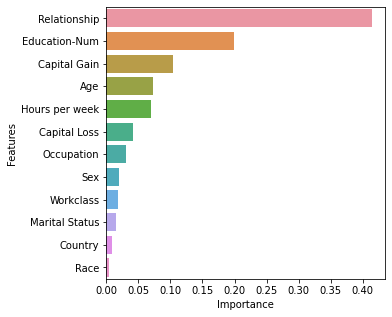

In [39]:
feature_importances, feature_order = get_feature_importances(clf_a)
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))
plt.savefig('figures/adult-orig-imp.pdf', bbox_inches='tight')

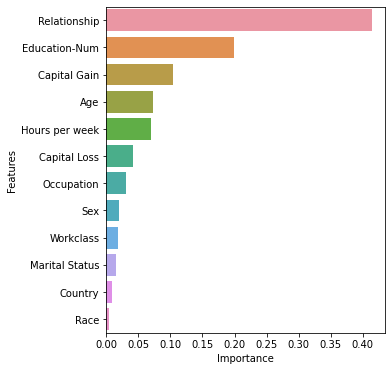

In [8]:
feature_importances, feature_order = get_feature_importances(clf_b)
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 6))

In [9]:
clf_b.feature_importances_ - clf_a.feature_importances_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [6]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

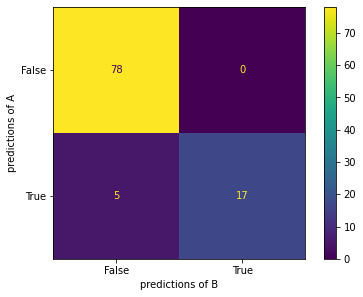

In [22]:
comparer.plot_confusion_matrix(X_explain)
plt.savefig('figures/adult-cf-modinfl.pdf')

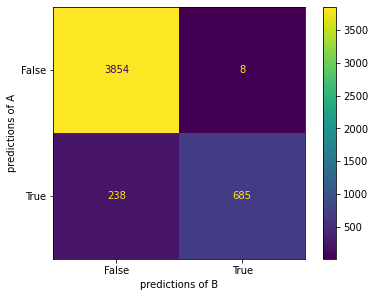

In [23]:
comparer.plot_confusion_matrix(X_explain_test)
plt.savefig('figures/adult-cf-modinfl-test.pdf')

In [40]:
y_pred_a = clf_a.predict(X_explain)
y_pred_b = clf_b.predict(X_explain)
mask = y_pred_a != y_pred_b
df = pd.DataFrame(X_explain[mask], columns=feature_names, index=np.where(mask)[0])
instances_without_noise_indices = df.index.to_numpy()
df

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
34,50.0,4.0,13.0,2.0,5.0,4.0,4.0,1.0,0.0,0.0,45.0,39.0
49,32.0,4.0,13.0,2.0,12.0,4.0,4.0,1.0,0.0,0.0,40.0,39.0
53,46.0,4.0,10.0,2.0,14.0,4.0,4.0,1.0,0.0,0.0,48.0,39.0
54,32.0,4.0,13.0,2.0,12.0,4.0,4.0,1.0,0.0,0.0,44.0,39.0
60,42.0,4.0,10.0,4.0,4.0,0.0,4.0,0.0,0.0,2444.0,40.0,39.0


In [42]:
print(df.T.to_latex(float_format=lambda x: '{:.0f}'.format(x) if isinstance(x, float) else x))

\begin{tabular}{lrrrrr}
\toprule
{} &  34 &  49 &  53 &  54 &   60 \\
\midrule
Age            &  50 &  32 &  46 &  32 &   42 \\
Workclass      &   4 &   4 &   4 &   4 &    4 \\
Education-Num  &  13 &  13 &  10 &  13 &   10 \\
Marital Status &   2 &   2 &   2 &   2 &    4 \\
Occupation     &   5 &  12 &  14 &  12 &    4 \\
Relationship   &   4 &   4 &   4 &   4 &    0 \\
Race           &   4 &   4 &   4 &   4 &    4 \\
Sex            &   1 &   1 &   1 &   1 &    0 \\
Capital Gain   &   0 &   0 &   0 &   0 &    0 \\
Capital Loss   &   0 &   0 &   0 &   0 & 2444 \\
Hours per week &  45 &  40 &  48 &  44 &   40 \\
Country        &  39 &  39 &  39 &  39 &   39 \\
\bottomrule
\end{tabular}



In [16]:
dfd = pd.DataFrame(X_display_explain[mask], columns=feature_names, index=np.where(mask)[0])
dfd

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
34,50.0,Private,13.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,45.0,United-States
49,32.0,Private,13.0,Married-civ-spouse,Sales,Husband,White,Male,0.0,0.0,40.0,United-States
53,46.0,Private,10.0,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,0.0,48.0,United-States
54,32.0,Private,13.0,Married-civ-spouse,Sales,Husband,White,Male,0.0,0.0,44.0,United-States
60,42.0,Private,10.0,Never-married,Exec-managerial,Not-in-family,White,Female,0.0,2444.0,40.0,United-States


In [9]:
mask = clf_a.predict(X_explain_test) != clf_b.predict(X_explain_test)
pd.DataFrame(X_display_explain_test[mask], columns=feature_names, index=np.where(mask)[0]).describe()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
count,246.0,246,246.0,246,246,246,246,246,246.0,246.0,246.0,246
unique,49.0,7,10.0,6,11,5,5,2,6.0,5.0,16.0,13
top,44.0,Private,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,40.0,United-States
freq,15.0,157,107.0,239,77,225,218,231,239.0,242.0,168.0,216


In [48]:
df = pd.DataFrame(X_explain, columns=feature_names)
dfe = pd.DataFrame(X_display_explain, columns=feature_names)

In [53]:
indices = [np.where(df['Relationship'] == value)[0][0] for value in np.unique(df['Relationship'])]
[(df.loc[idx, 'Relationship'].astype(int), dfe.loc[idx, 'Relationship']) for idx in indices]

[(0, ' Not-in-family'),
 (1, ' Unmarried'),
 (2, ' Other-relative'),
 (3, ' Own-child'),
 (4, ' Husband'),
 (5, ' Wife')]

In [ ]:
np.unique()

# Additional Material

In [36]:
approaches = ['baseline', 'diro2c', 'shap']
metrics_per_approach = []
for approach in approaches:
    with open(f'data/fidelity-{approach}.pickle', 'rb') as f:
        metrics_per_approach.append((approach, pickle.load(f)))

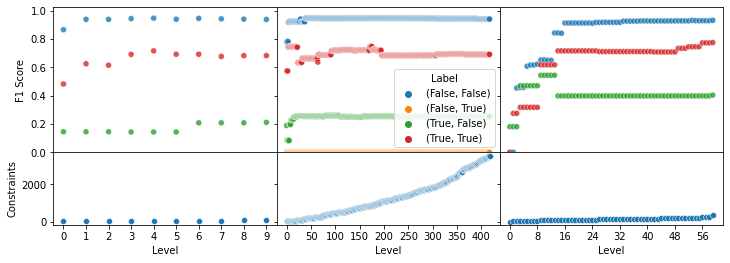

In [43]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(3*4, 4), sharex='col', sharey='row', gridspec_kw={'height_ratios': [2,1]})
for (approach, (grouped_metrics, constraints)), axs_col in zip(metrics_per_approach, axs.T):
    sns.scatterplot(data=grouped_metrics, x='Level', y='F1 Score', hue='Label', hue_order=comparer.class_names, alpha=0.8, ax=axs_col[0], legend=approach == 'diro2c')
    sns.scatterplot(data=constraints, ax=axs_col[1])
    axs_col[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs_col[0].set_ylim((0, 1.025))
plt.subplots_adjust(wspace=.0, hspace=.0)
plt.savefig('figures/adult-fidelity.pdf', bbox_inches='tight')

In [18]:
import explainers

In [19]:
with open('explanations/indiv.log_odds.shap', 'rb') as f:
    shap_values = pickle.load(f)

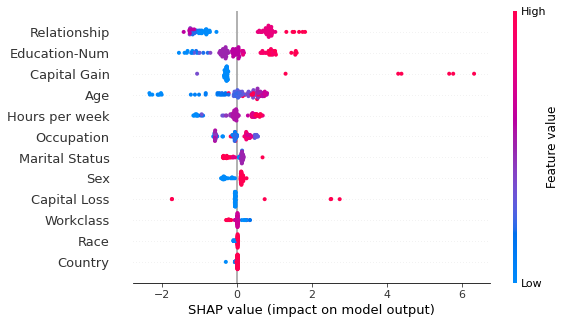

In [20]:
feature_order, feature_importance = explainers.calc_feature_order(shap_values[:, :, 'A.True'])
explainers.plot_feature_importance_scatter(shap_values[:, :, 'A.True'],
                                           feature_order=feature_order,
                                           max_display=len(feature_names),
                                           plot_size=(8,5))

In [21]:
focus_class = 'A.True'
feature_idx, feature = comparer.check_feature('Age')
compare_feature = 'Education-Num'

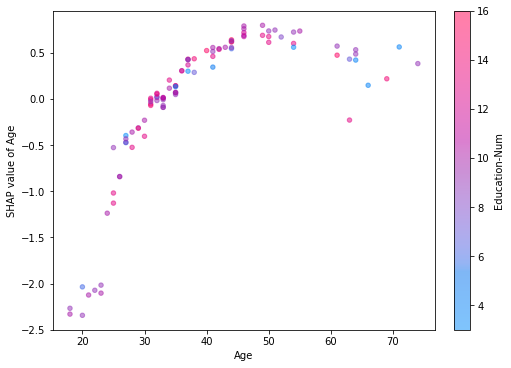

In [22]:
explainers.plot_feature_dependence(shap_values[:, :, focus_class], feature, alpha=0.5,
                                   color=shap_values[:, compare_feature, focus_class].data, color_label=compare_feature)

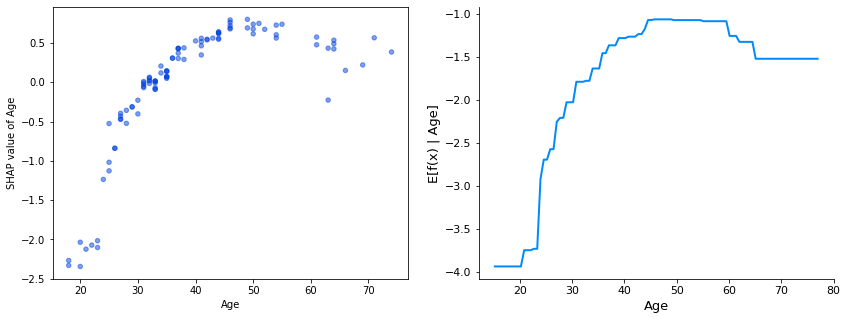

In [26]:
fig, axs = plt.subplots(ncols=2, figsize=(2*7, 5))
explainers.plot_feature_dependence(shap_values[:, :, focus_class], feature_idx, alpha=0.5, ax=axs[0])
shap.plots.partial_dependence(ind=feature_idx,
                              model=lambda X: comparer.predict_combined_log_odds(X)[:, 1],
                              data=X_explain,
                              feature_names=feature_names,
                              ice=False, hist=False, ax=axs[1])

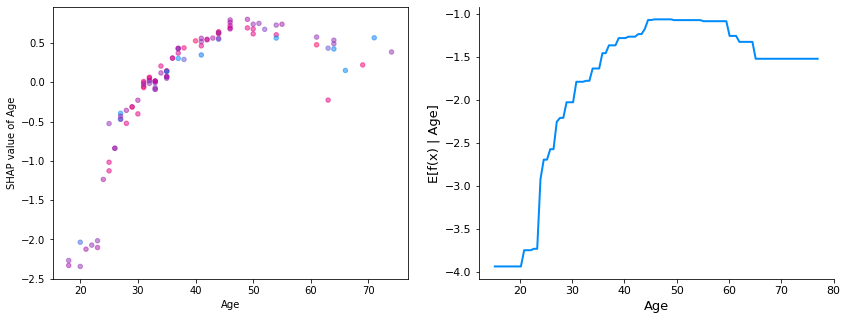

In [28]:
fig, axs = plt.subplots(ncols=2, figsize=(2*7, 5))
explainers.plot_feature_dependence(shap_values[:, :, focus_class], feature_idx, alpha=0.5, ax=axs[0],
                        color=shap_values[:, compare_feature, focus_class].data, color_label=compare_feature)
shap.plots.partial_dependence(ind=feature_idx,
                              model=lambda X: comparer.predict_combined_log_odds(X)[:, 1],
                              data=X_explain,
                              feature_names=feature_names,
                              ice=False, hist=False, ax=axs[1])